---
title: "Theory of RL II: Multi-Armed Bandits"
date: "2021-04-22"
image: "image.png"
format:
  html:
    code-fold: show
    code-line-numbers: false
jupyter: python3
---

**Bandit problems** are a special case of the RL problem in which there is **only a single state**. The name comes from slot machines which have a single lever (arm) and the very bad habit of stealing your money. You can imagine the multi-armed (also called k-armed) setting as follows: You are in a casino and face $k$ slot machines, each having an unknown probability of returning the reward. Your goal is to maximize your winnings in the long run by choosing the slot machine(s) with the highest reward probability. 

Let's look at multi-armed bandits in RL terms: At each time step $t$, the agent has a choice among $k$ different actions. His reward $R_t$ is chosen from a stationary probability distribution that depends on the selected action $A_t$. The expected reward (that is, the true *value*) of each action $a$, $q_*(a)$, is unknown to the agent:

$$q_*(a)=\mathbb{E} \left[R_t \vert A_t = a \right]$$

The agent's estimate of $q_*(a)$ at time step $t$ is denoted $Q_t(a)$. The goal of the agent is to maximize the cumulative reward $\sum_{t=1}^{T} R_t$ which is the same as to minimize the so-called **regret** (or loss), $\mathcal{L_t}$, due to not picking the optimal action

$$\mathcal{L}_T = \mathbb{E} \left[ \sum_{t=1}^{T} \left(v_* - q_*(A_t)\right) \right],$$

where $v_*$ denotes the true value of the optimal action $a_*$. 

As we will see, this simplified version of the Markov decision process (MDP) is particularly suited to investigate the **exploration vs. exploitation trade-off** that arises in RL. Imagine you can choose between 10 slot machines and randomly select machine \#5 to begin with. Say, you get the reward. Should you keep choosing machine \#5? In RL, this is called *exploitation*: you choose the best option you know about. But since you've tried only one machine, there certainly could be another one that is better (that is, has a higher reward probability). To find out whether there in fact is, you must try other slot machines. This is called *exploration* since you explore other options to possibly find one that offers a higher reward probability than the ones you tried out before. Likely neither exploitation (only if your first choice is indeed the best) nor exploration (only if all choices are equally good) alone will suffice to maximize the cumulative reward. This is why agents must balance exploitation and exploration in order to reach their goal. Don't forget that the stochasticity of the environment adds to the problem. While you got the reward when trying machine \#5 for the first time, you may lose the second and third time you try it. This is why an agent needs a good strategy for reliably estimating the action-values by trial-and-error.

Note: A general intro into the topic can be found [here](https://arxiv.org/abs/1904.07272). For more on practical applications of multi-armed bandits, see [here](https://arxiv.org/abs/1904.10040). 

Let's put this in code. We'll write a class `Bandit` that implements a multi-armed bandit with $k$ arms where each arm has a given probability of returning the reward (this is known as a Bernoulli bandit).

In [ ]:
#| code-fold: true

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
#| code-fold: true

rng = np.random.default_rng(7)

In [197]:
#| code-fold: true

class Bandit:
    def __init__(self, k, probs=None):
        self.k = k
        if probs is None:
            self.probs = rng.random(self.k)
        else:
            self.probs = probs

        self.best_prob = np.max(self.probs)
        self.best_arm = np.argmax(self.probs)
        self.sorted_arms = np.argsort(self.probs)

    def gen_reward(self, k):
        return rng.binomial(1, self.probs[k])
    
    def plot(self, highlight_best=False):
        _, ax = plt.subplots(figsize=(4, 3))

        ax.plot(np.arange(0, self.k), self.probs, "o", color="black", ms=5)
        ax.grid(visible=True, which="both", lw=0.3)
        ax.set(ylim=(0, 1),
               xticks=np.arange(self.k),
               xlabel="Arms",
               ylabel="Reward probability")
        ax.tick_params(axis="y", length=0)
        for spine in ["left", "right"]:
            ax.spines[spine].set_visible(False)
        if highlight_best:
            x, y = self.best_arm, self.best_prob
            ax.plot(x, y, "o", color="red", fillstyle="none", ms=10, zorder=2)

Let's look at our example bandit. The highlighted arm (#1 with the red circle) is the arm with the highest reward probability. Arms #5 and #7 come in second and third.

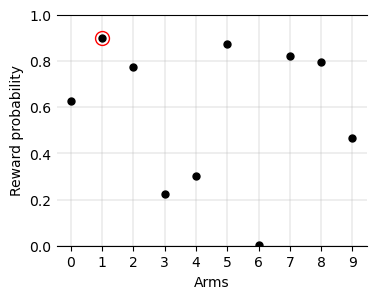

In [198]:
bandit = Bandit(10)
bandit.plot(highlight_best=True)

In [199]:
list(zip(bandit.sorted_arms, bandit.probs[bandit.sorted_arms]))[::-1]

[(1, 0.8972138009695755),
 (5, 0.8735534453962619),
 (7, 0.8212284183827663),
 (8, 0.7970694287520462),
 (2, 0.7756856902451935),
 (0, 0.625095466604667),
 (9, 0.4679349528437208),
 (4, 0.30016628491122543),
 (3, 0.22520718999059186),
 (6, 0.005265304565574724)]

## Action-value Methods

Unsurprisingly, methods for estimating the values of actions are called action-value methods. Since the true value of an action is the mean reward the agent gets when selecting this action, the most obvious way to estimate this is the **sample-average method** which just averages the actually observed rewards for each action:

$$Q_t(a) = \dfrac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}},$$

where $\mathbb{1}$ is a binary indicator function that is $1$ if the corresponding expression is true and $0$ otherwise. Put simply, we divide the sum of the rewards the agent has received so far for taking action $a$ by the number of times he selected action $a$. By the law of large numbers $Q_t(a)$ converges to $q_*(a)$ as the denominator goes to infinity. To avoid division by zero (when the agent hasn't chosen action $a$ yet), we need to define a default value for $Q_t(a)$, say $0$ for now.

For a specific action $a$ this could be implemented like this:

$$Q_n = \dfrac{R_1 + R_2 + \dots + R_{n-1}}{n-1},$$

where $Q_n$ denotes the action-value estimate after the action has been selected $n{-}1$ times. The disadvantages of this implementation, however, are potentially huge requirements for memory (storing all the rewards) and computation (doing this calculation again and again). Thus, it is much more efficient to compute the estimates incrementally with a simple **update rule** that comes with constant computation per time step as well as constant memory (only for $Q_n$ and $n$):

$$Q_{n+1} = Q_n + \dfrac{1}{n} \big[ R_n - Q_n \big]$$

Note that the pattern of this update rule

$$\text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} \left[ \text{Target} - \text{OldEstimate} \right]$$

won't occur here for the last time. To improve our estimate, we calculate the **error** $\text{Target} - \text{OldEstimate}$ and try to reduce it by taking a step towards the **target**. The size of that step is determined by the step-size parameter $\alpha_t(a)$. In the simple algorithm presented above $\alpha = \dfrac{1}{n}$.

## Exploration Strategies

Now that we have a simple method for estimating action values, we can turn our attention to some classic exploration strategies. But first, let's see why the pure exploitation and pure exploration strategies don't work. 

Always exploiting means always selecting the action with the highest estimated value (or one of the actions if there are multiple ones with the highest estimated value) and is called the **greedy** action selection method:

$$A_t = \text{argmax}_{a} Q_t(a)$$

Actions that appear to be inferior are never sampled under this strategy. Think back to the casino example one more time: Imagine you define the default values to be $0$ for every slot machine, randomly select machine \#5 and get the reward. Under a greedy strategy, you will always choose machine \#5 from now on since it has the highest action-value estimate. Only if the estimate falls below zero, you will try out another machine. Thus, if there are no negative rewards in the environment the greedy method will always stick to the first action. It is obvious why this doesn't guarantee the best long-term reward. 

The other extreme, pure random exploration, is not a useful strategy either. You will get very good action-value estimates in the long run by sampling every option, but don't use your knowledge to maximize your rewards. This is why you need to balance the gathering of information (exploration) and the use of information (exploitation) to reach your goal.

Let's see how this plays out with our example bandit. We define a `Strategy` class that allows us easily apply specific strategies to our problem.

In [200]:
N_STEPS = 1000

class Strategy:
    def __init__(self, bandit, n_steps=1000):
        self.bandit = bandit
        self.n_steps = n_steps

        self.Q = np.zeros(self.bandit.k)
        self.n = np.zeros(self.bandit.k, dtype="int")

        self.rewards = np.empty(self.n_steps, dtype="int")
        self.actions = np.empty(self.n_steps, dtype="int")
        self.regrets = np.empty(self.n_steps)

    def step(self):
        raise NotImplementedError
    
    def update(self, action, reward, t):
        self.n[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.n[action]
        self.rewards[t] = reward
        self.actions[t] = action
        self.regrets[t] = self.bandit.best_prob - self.bandit.probs[action]

    def run(self):
        for t in range(self.n_steps):
            action = self.step()
            reward = self.bandit.gen_reward(action)
            self.update(action, reward, t)
    
    def reset(self):
        self.Q = np.zeros(self.bandit.k)
        self.n = np.zeros(self.bandit.k, dtype="int")
        self.rewards = np.empty(self.n_steps, dtype="int")
        self.actions = np.empty(self.n_steps, dtype="int")
        self.regrets = np.empty(self.n_steps)
    
    def plot_actions(self):
        _, ax = plt.subplots(figsize=(6, 3))
        ax.scatter(np.arange(self.n_steps), self.actions, c="black", alpha=0.5)
        ax.set(xticks=np.linspace(0, self.n_steps, 5),
               yticks=np.arange(self.bandit.k),
               xlabel="Steps",
               ylabel="Arms")
        ax.grid()

def plot_actions(strategy):
    strategy.run()
    strategy.plot_actions()

In [201]:
class GreedyExploitation(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS):
        super(GreedyExploitation, self).__init__(bandit, n_steps)
    
    def __repr__(self):
        return "PureExploitation"
    
    def step(self):
        if not np.any(self.Q):
            return rng.integers(0, self.bandit.k)
        else:
            return np.argmax(self.Q)

As we can see below, the greedy strategy starts by picking a random action (arm #8 in this case). If, by chance, this arm returns the reward, the strategy will stay with this arm regardless of its reward probability. Otherwise the strategy would randomly choose arms until one returns the reward.

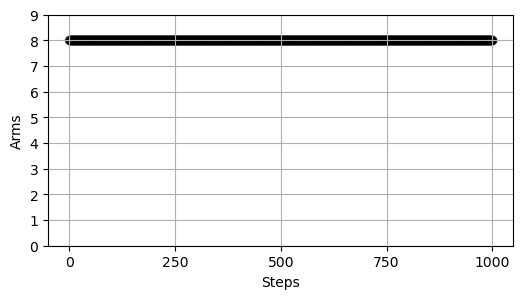

In [202]:
#| code-fold: true

plot_actions(GreedyExploitation(bandit))

In [203]:
class RandomExploration(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS):
        super(RandomExploration, self).__init__(bandit, n_steps)

    def __repr__(self):
        return "PureExploration"

    def step(self):
        return rng.integers(0, self.bandit.k)

The random exploration strategy is the other extreme; it continues to explore all possible actions.

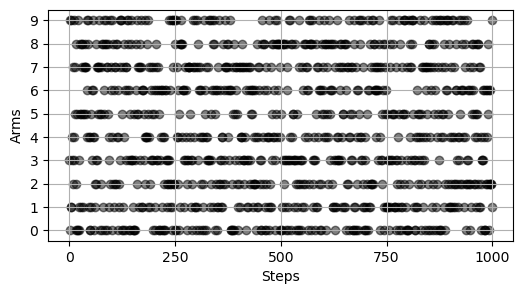

In [204]:
#| code-fold: true

plot_actions(RandomExploration(bandit))

### Epsilon-greedy Strategy

A simple improvement of the naive greedy approach is to exploit most of the time, but, with small probability $\epsilon$, sometimes select an action randomly (i.e. independently of the action-value estimates), thereby exploring the other options. This strategy is called **$\epsilon$-greedy** and is guaranteed to converge to the true action-values, assuming that, in the limit, every action will be sampled an infinite number of times. $\epsilon$-greedy turns out to work surprisingly well in many problems.

In [205]:
class EpsilonGreedy(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS, epsilon=0.04):
        super(EpsilonGreedy, self).__init__(bandit, n_steps)
        self.epsilon = epsilon

    def __repr__(self):
        return f"EpsilonGreedy, epsilon={self.epsilon}"

    def step(self):
        if rng.random() < self.epsilon:
            return rng.integers(0, self.bandit.k)
        else:
            return np.argmax(self.Q)

$\epsilon$ is a hyperparameter that we have to choose depending on the problem. In the example below with $\epsilon=0.04$, the epsilon-greedy strategy finds the best arm after around 600 steps.

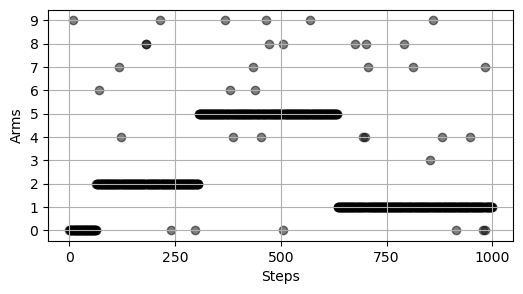

In [206]:
#| code-fold: true

plot_actions(EpsilonGreedy(bandit))

### Decaying Epsilon-greedy Strategy

Intuitively, an agent's need for exploration is high in the beginning when he doesn't have much information about the environment yet, but gets progressively smaller because he improves his value estimations as he gets more and more experience. This intuition can be implemented into the $\epsilon$-greedy strategy by starting with a higher $\epsilon$ to emphasize exploration early on and decaying it going forward to focus more on exploitation. Note that there are plenty of ways to decay $\epsilon$, from simple linear decaying to more sophisticated approaches. 

In [207]:
class EpsilonGreedyLinDecay(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS, decay_ratio=0.3, start_eps=1.0, min_eps=0.01):
        super(EpsilonGreedyLinDecay, self).__init__(bandit, n_steps)
        self.decay_ratio = decay_ratio
        self.start_eps = start_eps
        self.min_eps = min_eps

    def __repr__(self):
        return f"EpsilonGreedyLinDecay, decay_ratio={self.decay_ratio}, start_eps={self.start_eps}, min_eps={self.min_eps}"

    def step(self, t):
        epsilon = (1 - t / (self.decay_ratio * self.n_steps)) * (self.start_eps - self.min_eps) + self.min_eps
        epsilon = np.clip(epsilon, self.min_eps, self.start_eps)
        if rng.random() < epsilon:
            return rng.integers(0, self.bandit.k)
        else:
            return np.argmax(self.Q)

    def run(self):
        for t in range(self.n_steps):
            action = self.step(t)
            reward = self.bandit.gen_reward(action)
            self.update(action, reward, t)

The decay introduces more hyperparameters that we need to tune for our problem. With the default setting defined by the epsilon-greedy strategy with linear decay, we settle on the second-best arm:

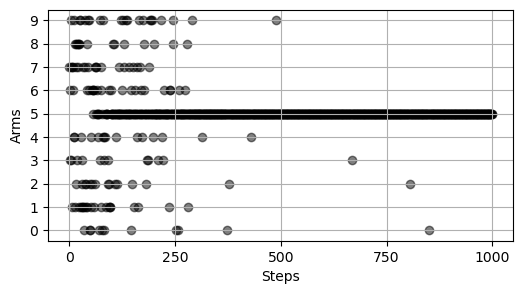

In [208]:
#| code-fold: true

plot_actions(EpsilonGreedyLinDecay(bandit))

In [209]:
class EpsilonGreedyExpDecay(Strategy):
    def __init__(self, bandit, n_steps=1000, decay_ratio=0.3, start_eps=1.0, min_eps=0.01):
        super(EpsilonGreedyExpDecay, self).__init__(bandit, n_steps)
        self.decay_ratio = decay_ratio
        self.start_eps = start_eps
        self.min_eps = min_eps

        epsilons = (0.01 / np.logspace(-2, 0, int(self.n_steps * self.decay_ratio)))
        epsilons = epsilons * (self.start_eps - self.min_eps) + self.min_eps
        self.epsilons = np.pad(epsilons, (0, int((1 - self.decay_ratio) * self.n_steps)), 'edge')

    def __repr__(self):
        return f"EpsilonGreedyExpDecay, decay_ratio={self.decay_ratio}, start_eps={self.start_eps}, min_eps={self.min_eps}"

    def step(self, t):
        if rng.random() < self.epsilons[t]:
            return rng.integers(0, self.bandit.k)
        else:
            return np.argmax(self.Q)

    def run(self):
        for t in range(self.n_steps):
            action = self.step(t)
            reward = self.bandit.gen_reward(action)
            self.update(action, reward, t)

The same strategy with exponential decay finds the best arm, however.

Naturally, chance plays a role here. To see which exploration strategy really works best we would need to rerun our experiment with many different seeds.

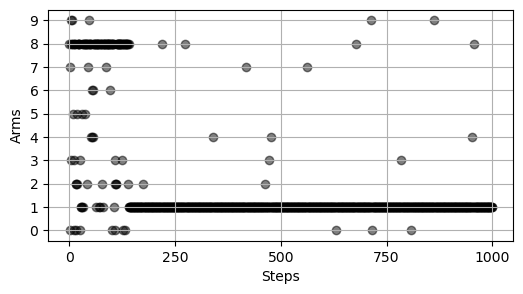

In [210]:
#| code-fold: true

plot_actions(EpsilonGreedyExpDecay(bandit))

### Softmax Strategy

Depending on the problem, it can be a disadvantage of the $\epsilon$-greedy strategy that it selects all actions with equal probability when exploring. The softmax strategy remedies this by making the probability of taking an action proportional to its current Q-value estimate. Put simply, actions with high value estimates are selected more frequently than actions with low estimates. This strategy is also called **Boltzmann exploration** since the agent **draws actions from a Boltzmann (softmax) distribution over the action-value estimates**. Note that the agent's preference for actions with high estimates can be controlled by the **temperature** parameter $\tau$: the agent selects the action with the highest value estimate as $\tau$ approaches $0$, and samples an action uniformly as $\tau$ approaches infinity.

$$\pi(a) = \dfrac{\exp \left( \dfrac{Q(a)}{\tau} \right)}{\sum_{b=0}^{n} \exp \left( \dfrac{Q(b)}{\tau} \right)}$$

In [211]:
class Softmax(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS, decay_ratio=0.05, start_temp=1000, min_temp=1e-10):
        super(Softmax, self).__init__(bandit, n_steps)
        self.decay_ratio = decay_ratio
        self.start_temp = start_temp
        self.min_temp = min_temp

    def __repr__(self):
        return f"Softmax, decay_ratio={self.decay_ratio}, start_temp={self.start_temp}, min_temp={self.min_temp}"

    def step(self, t):
        temp = (1 - t / (self.n_steps * self.decay_ratio)) * (self.start_temp - self.min_temp) + self.min_temp
        temp = np.clip(temp, self.min_temp, self.start_temp)
        Q_scaled = self.Q / temp
        Q_exp = np.exp(Q_scaled - np.max(Q_scaled))
        probs = Q_exp / np.sum(Q_exp)
        return rng.choice(np.arange(len(probs)), size=1, p=probs).item()

    def run(self):
        for t in range(self.n_steps):
            action = self.step(t)
            reward = self.bandit.gen_reward(action)
            self.update(action, reward, t)

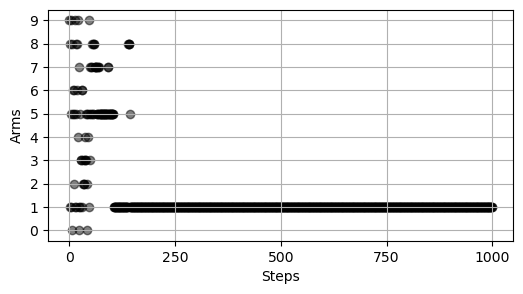

In [212]:
#| code-fold: true

plot_actions(Softmax(bandit))

### Optimistic Initialization

Until now, we simply used $0$ as the default value for actions that are still unexplored, thereby injecting an initial bias into our method. We can use this bias as a simple way to improve the greedy approach by setting **optimistic initial values**. What does that mean? If we set the initial estimate to a high value, the agent will be "disappointed" by the rewards early on which encourages exploration until the estimates improve and start converging to the true values. You can see below that this can work quite well in the bandit example. Optimistic initial values have several drawbacks, though. They assume that we have some knowledge about what a "high" value in the environment is (if we set it too high, the algorithm needs many time steps to get more realistic estimates; if we set it too low, the strategy isn't optimistic and doesn't work as intended) and they don't work in nonstationary environments since they only encourage exploration in the beginning.

In [213]:
class OptimisticInitialization(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS, init_val=1.):
        super(OptimisticInitialization, self).__init__(bandit, n_steps)
        self.init_val = init_val
        self.Q = np.full(self.bandit.k, self.init_val)
        self.n = np.ones(self.bandit.k, dtype="int")

    def __repr__(self):
        return f"OptimisticInitialization, init_val={self.init_val}"

    def step(self):
        return np.argmax(self.Q)

    def reset(self):
        self.Q = np.full(self.bandit.k, self.init_val)
        self.n = np.ones(self.bandit.k, dtype="int")

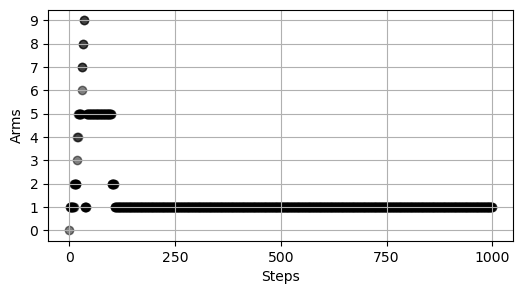

In [214]:
#| code-fold: true

plot_actions(OptimisticInitialization(bandit))

### Upper-Confidence-Bound (UCB) Action Selection

Another approach that follows the principle of "optimism in the face of uncertainty" is the UCB strategy which accounts for both the estimated action-value *and* the uncertainty of the estimate by greedily selecting the action that maximizes the upper confidence bound. To implement this method, we add an uncertainty bonus $U(a)$ to the Q-value estimates and always select the action with the highest total value. The idea is that the true action-value is below that upper confidence bound with high probability. Put simply, we select the action with the highest *potential* to be optimal. Let's look at the math:

$$A_t = \text{argmax}_a \left[ Q_t(a) + U_t{a}\right] = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\dfrac{\ln{t}}{N_t(a)}}\right],$$

where $\ln t$ denotes the natural logarithm of $t$, $N_t(a)$ denotes the number of times the agent selected action $a$ prior to time step $t$, and $c$ is a hyperparameter that controls the size of the bonus (and hence the agent's preference for exploration). As a result, an action that has been selected only a few times after a number of trials has higher associated uncertainty (and higher need for exploration) than an action that was sampled often. As the agent gets more experience and thus more confident in his estimates, the effect of the uncertainty term fades.

In [215]:
class UCB(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS, c=0.2):
        super(UCB, self).__init__(bandit, n_steps)
        self.c = c

    def __repr__(self):
        return f"UCB, c={self.c}"

    def step(self, t):
        if t < self.bandit.k:
            return t
        else:
            return np.argmax(self.Q + self.c * np.sqrt(np.log(t) / self.n))

    def run(self):
        for t in range(self.n_steps):
            action = self.step(t)
            reward = self.bandit.gen_reward(action)
            self.update(action, reward, t)

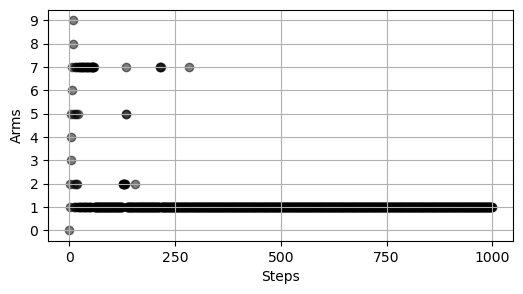

In [216]:
#| code-fold: true

plot_actions(UCB(bandit))

### Thompson Sampling

While the UCB strategy is deterministic, Thompson sampling is a sample-based approach for selecting actions that essentially comes down to Bayesian inference. For the Bernoulli bandit, we assume that each Q-value estimate $Q(a)$ follows a Beta distribution, $\text{Beta}(\alpha, \beta)$, which is parameterized by two positive parameters $\alpha$ and $\beta$ that correspond to the number of times we got the reward versus the number of times we didn't when we took the action. Initially, we set the parameters based on our beliefs for every action, e.g. $\alpha=1$ and $\beta=1$ when we believe (without confidence) that the reward probability is $0.5$. Then, at each time step $t$, we sample an expected reward for every action from the respective prior distribution $\text{Beta}(\alpha_i, \beta_i)$ and simply select the best available action. After we have observed the true reward, we update the action's Beta distribution accordingly.

In [217]:
class ThompsonSampling(Strategy):
    def __init__(self, bandit, n_steps=N_STEPS, alpha=1, beta=1):
        super(ThompsonSampling, self).__init__(bandit, n_steps)
        self.alpha = alpha
        self.beta = beta
        self.alphas = np.full(self.bandit.k, self.alpha)
        self.betas = np.full(self.bandit.k, self.beta)

    def __repr__(self):
        return f"ThompsonSampling, alpha={self.alpha}, beta={self.beta}"

    def step(self):
        return np.argmax(rng.beta(self.alphas, self.betas))

    def run(self):
        for t in range(self.n_steps):
            action = self.step()
            reward = self.bandit.gen_reward(action)
            self.alphas[action] += reward
            self.betas[action] += (1 - reward)
            self.update(action, reward, t)

    def reset(self):
        self.alphas = np.full(self.bandit.k, self.alpha)
        self.betas = np.full(self.bandit.k, self.beta)

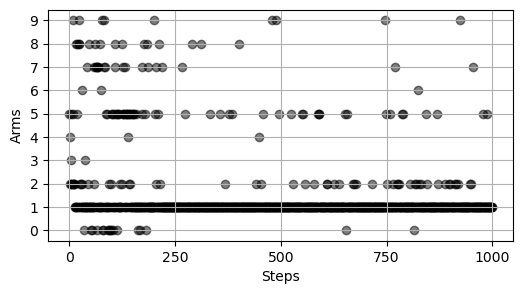

In [218]:
#| code-fold: true

plot_actions(ThompsonSampling(bandit))

### A quick comparison

Finally, we can do a quick comparison using data from 20 runs:

In [265]:
def experiment(k=10, n_steps=1000, runs=20):
    regrets = defaultdict(list)

    for run in range(runs):
        bandit = Bandit(k)
        
        for strategy in [GreedyExploitation(bandit, n_steps=n_steps),
                         RandomExploration(bandit, n_steps=n_steps),
                         # EpsilonGreedy(bandit, n_steps=n_steps, epsilon=0.01),
                         EpsilonGreedy(bandit, n_steps=n_steps, epsilon=0.025),
                         # EpsilonGreedy(bandit, n_steps=n_steps, epsilon=0.04),
                         EpsilonGreedyLinDecay(bandit, n_steps=n_steps, decay_ratio=0.3, start_eps=1.0, min_eps=0.01),
                         # EpsilonGreedyLinDecay(bandit, n_steps=n_steps, decay_ratio=0.25, start_eps=1.0, min_eps=0.01),
                         # EpsilonGreedyLinDecay(bandit, n_steps=n_steps, decay_ratio=0.2, start_eps=1.0, min_eps=0.01),
                         # EpsilonGreedyExpDecay(bandit, n_steps=n_steps, decay_ratio=0.3, start_eps=1.0, min_eps=0.01),
                         EpsilonGreedyExpDecay(bandit, n_steps=n_steps, decay_ratio=0.25, start_eps=1.0, min_eps=0.01),
                         # EpsilonGreedyExpDecay(bandit, n_steps=n_steps, decay_ratio=0.2, start_eps=1.0, min_eps=0.01),
                         # Softmax(bandit, n_steps=n_steps, decay_ratio=0.075, start_temp=1000, min_temp=1e-10),
                         Softmax(bandit, n_steps=n_steps, decay_ratio=0.05, start_temp=1000, min_temp=1e-10),
                         # Softmax(bandit, n_steps=n_steps, decay_ratio=0.03, start_temp=1000, min_temp=1e-10),
                         # UCB(bandit, n_steps=n_steps, c=0.3),
                         # UCB(bandit, n_steps=n_steps, c=0.2),
                         UCB(bandit, n_steps=n_steps, c=0.1),
                         ThompsonSampling(bandit, n_steps=n_steps)]:
        
            strategy.run()
            regrets[str(strategy)].append(strategy.regrets)

    fig, ax = plt.subplots(figsize=(10, 5))
    for strategy, result in regrets.items():
        ax.plot(np.arange(n_steps), np.cumsum(np.mean(result, axis=0)), label=strategy)
    
    ax.legend()

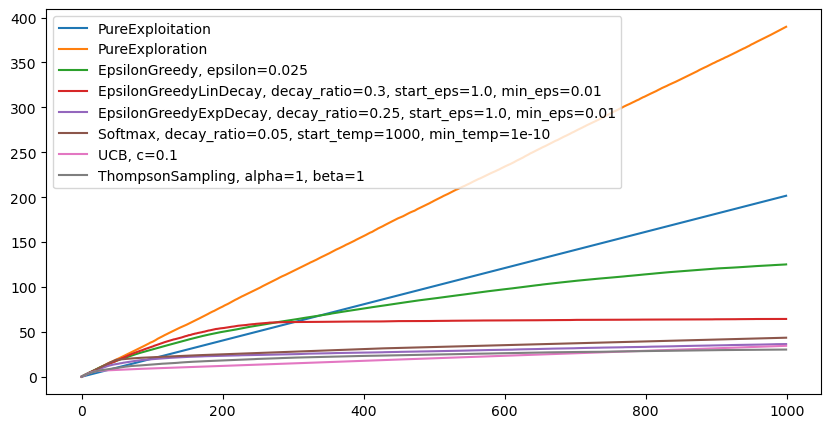

In [266]:
#| code-fold: true

experiment()

In the next post, we'll look at the bigger picture again and see how we can solve the RL problem with dynamic programming.